# Binning Studies

## Table of Contents
- [DNN output](#DNNoutput)<a href='#DNNoutput'></a> <br>
- [Signal Efficiency](#SignalEfficiency)<a href='#SignalEfficiency'></a> <br>
- [Significance Optimization](#SignificanceOptimization)<a href='#SignificanceOptimization'></a> <br>

In [4]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from collections import defaultdict
import os

mpl.rcParams['figure.figsize'] = (6,6)
mpl.rcParams['figure.dpi'] = 100
mpl.rcParams["image.origin"] = 'lower'

In [5]:
config = {
    "base_dir":        "/eos/home-b/bpinolin/ML_classification/output/",
    "plot_config":     "VBSOS",
    "cut":             "em_loose",
    "model_version":   "v2"
}

In [6]:
config_base_dir = os.path.join(config["base_dir"], config["plot_config"])

# create the model directory
model_dir   = os.path.join(config_base_dir, config["cut"] , "models",  config["model_version"])
os.makedirs(model_dir, exist_ok=True)

import yaml
model_config_file = open(model_dir + "/model_config.yml", "r")
model_config = yaml.safe_load(model_config_file)

for key in ["samples_version", "cols"]:
    config[key] = model_config[key]

In [7]:
# load numpy
samples_dir = os.path.join(config_base_dir, config["cut"] , "samples", config["samples_version"])
import pickle
signal = pickle.load(open(os.path.join(samples_dir, "for_training/signal_balanced.pkl"),     "rb"))
bkg    = pickle.load(open(os.path.join(samples_dir, "for_training/background_balanced.pkl"), "rb"))

In [8]:
X_sig = signal[config["cols"]].values
X_bkg = bkg[config["cols"]].values
Y_sig = np.ones(len(X_sig))
Y_bkg = np.zeros(len(X_bkg))
W_sig = (signal["weight_norm"]).values
W_bkg = (bkg["weight_norm"]).values
Wnn_sig = (signal["weight_"]).values
Wnn_bkg = (bkg["weight_"]).values

X = np.vstack([X_sig, X_bkg])
Y = np.hstack([Y_sig, Y_bkg])
W = np.hstack([W_sig, W_bkg])
Wnn = np.hstack([Wnn_sig, Wnn_bkg])

X[~np.isfinite(X)] = 9999

In [9]:
scaler = pickle.load(open(f"{model_dir}/scaler_model.pkl", "rb"))
X_scaled = scaler.fit_transform(X)

In [10]:
import tensorflow as tf

model = tf.keras.models.load_model(os.path.join(model_dir, "model.h5"))

model.summary()

W0416 19:00:45.214386 140246199662400 deprecation.py:323] From /cvmfs/sft.cern.ch/lcg/views/LCG_97python3/x86_64-centos7-gcc9-opt/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0416 19:00:45.862643 140246199662400 hdf5_format.py:258] Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                480       
_________________________________________________________________
batch_normalization_1 (Batch (None, 30)                120       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1550      
_________________________________________________________________
batch_normalization_2 (Batch (None, 50)                200       
_________________________________________________________________
activation_1 (Activation)    (None, 50)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)               

In [11]:
bkg_linf = bkg[config["cols"]].values
bkg_linf[~np.isfinite(bkg_linf)] = 9999

<a id = 'DNNoutput' ></a>
## DNN output

In [12]:
bkg["y"] = model.predict(scaler.transform(bkg_linf), batch_size=2048)
signal["y"] = model.predict(scaler.transform(signal[config["cols"]].values), batch_size=2048)

In [13]:
top = bkg[bkg["sample_name"] == "top"]

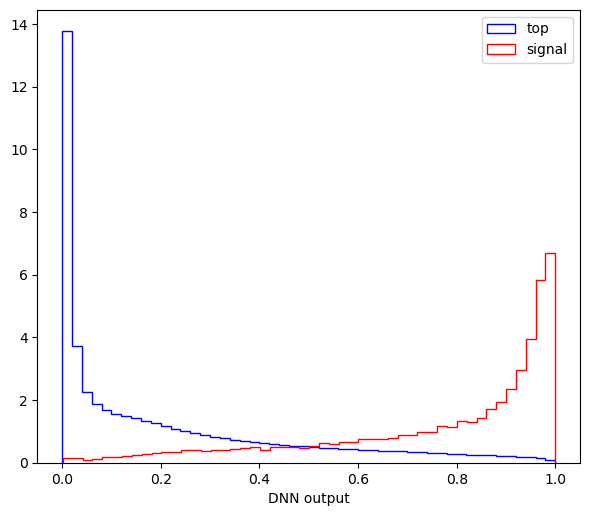

In [14]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)
plt.hist(top["y"],   bins=50, density=True, label="top",    histtype="step", color="blue")
plt.hist(signal["y"], bins=50,density=True, label="signal", histtype="step", color="red")
plt.xlabel("DNN output")
plt.legend()
plt.show()

 Initial number of background events = 5983.358371
 Initial number of signal events = 10.349853

 signal efficiency = 0.754
 background efficiency = 0.107

 significance (before) = 0.134 
 significance (after) = 0.309


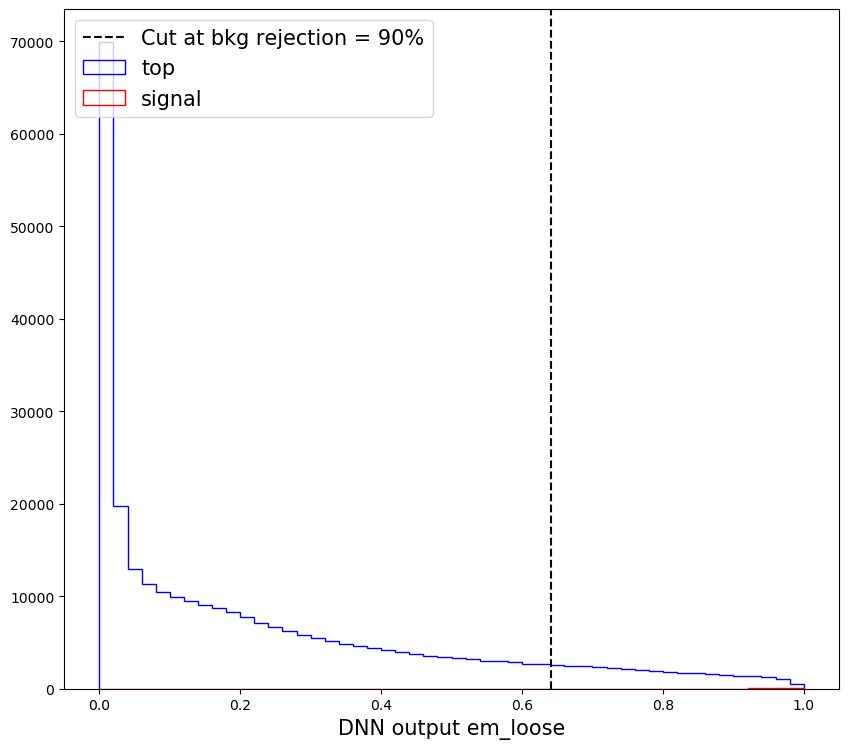

In [15]:
from math import sqrt
import matplotlib.patches as mpatches

lumi = 59.74

fig, ax1 = plt.subplots(figsize=(10,9), dpi=100)

B, B_bins, _ = plt.hist(top["y"],   weights=top.weight_*lumi, bins=50, label="top",  histtype="step", color="blue")
S, S_bins, _ = plt.hist(signal["y"], weights=signal.weight_*lumi, bins=50, label="signal", histtype="step", color="red")

B_width = B_bins[1] - B_bins[0]
S_width = S_bins[1] - S_bins[0]

Ni_B = B_width * sum(B[:])
Ni_S = S_width * sum(S[:])

print(" Initial number of background events = {:f}\n Initial number of signal events = {:f}\n".format(Ni_B, Ni_S))

bd = 1
int_B = 0

while (int_B < (0.1*Ni_B)):
    int_B = B_width * sum(B[-bd:])
    bd += 1

int_S = S_width * sum(S[-bd:])

plt.axvline(S_bins[-bd], 0, max(B), label='Cut at bkg rejection = 90%', color = "black", linestyle = "dashed")

print(" signal efficiency = {:.3f}\n background efficiency = {:.3f}\n".format(int_S/Ni_S, int_B/Ni_B))

print(" significance (before) = {:.3f} \n significance (after) = {:.3f}".format(Ni_S/sqrt(Ni_B), int_S/sqrt(int_B)))

plt.xlabel("DNN output "+config["cut"], fontsize=15)
plt.legend(loc="upper left", fontsize=15)
plt.show()

<a id = 'SignalEfficiency' ></a>
## Signal Efficiency

``cumulative``: a histogram is computed where each bin gives the counts in that bin plus all bins for smaller values. The last bin gives the total number of datapoints.

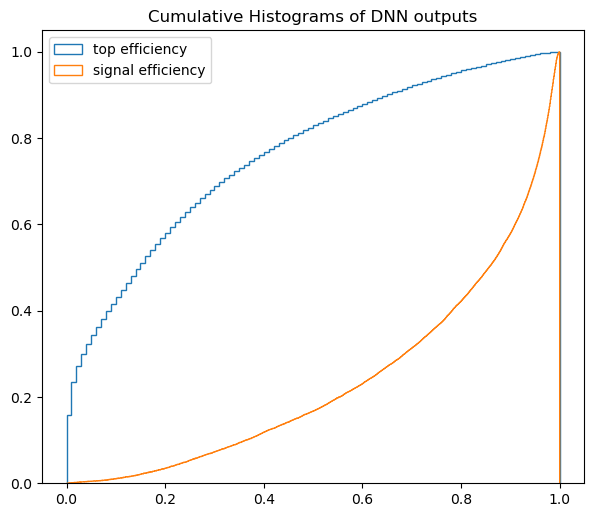

In [66]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

hcumul_bkg = plt.hist(bkg["y"], weights=bkg.weight_, bins=100,cumulative=True, density=True, range=(0,1),label="top efficiency", histtype="step")
hcumul = plt.hist(signal["y"], weights=signal.weight_, bins=1000,cumulative=True, density=True, range=(0,1),label="signal efficiency", histtype="step")

plt.title("Cumulative Histograms of DNN outputs")

plt.legend(loc='upper left')
plt.show()

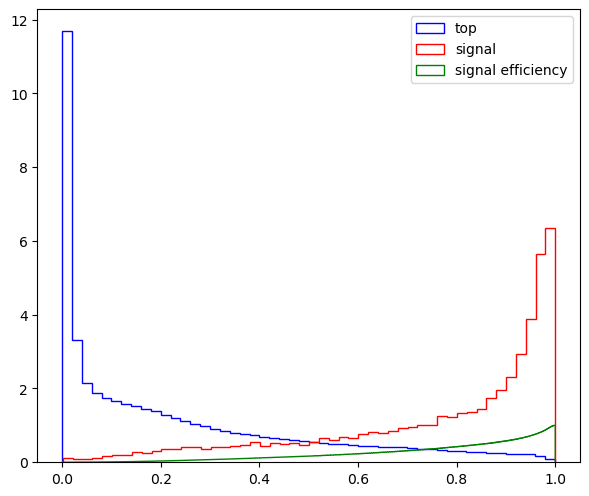

In [154]:
fig, ax1 = plt.subplots(figsize=(7,6), dpi=100)

plt.hist(top["y"],   weights=top.weight_,  bins=50, density=True, label="top", color='blue', histtype="step")
plt.hist(signal["y"], weights=signal.weight_, bins=50,density=True, label="signal", color='red', histtype="step")
plt.hist(signal["y"], weights=signal.weight_, bins=1000,cumulative=True, density=True, range=(0,1),label="signal efficiency", color='green', histtype="step")
plt.legend(loc='upper right')
plt.show()

Riscrivo l'istogramma cumulativo della DNN output di segnale sotto forma di ``TGrapgh``.

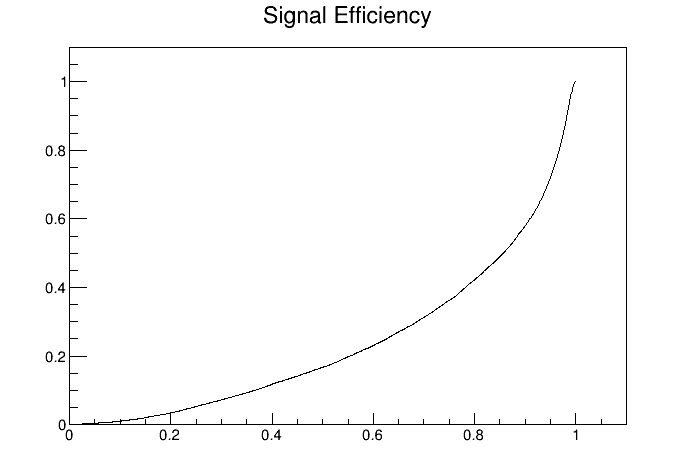

In [70]:
import ROOT as R

gr = R.TGraph()
L = len(hcumul[1])

for i in range(L-1):
    gr.SetPoint(i, (hcumul[1][i+1] + hcumul[1][i])/2, hcumul[0][i])
    
gr.SetPoint(L-1, 1., 1.)
gr.SetBit(R.TGraph.kIsSortedX)

c = R.TCanvas()
gr.SetTitle("Signal Efficiency")
gr.Eval
gr.Draw("APL")
c.Draw()